# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
from utils import Config, OUNoise, Replay
from agent import SelfPlayAgent
from models import Actor, Critic
from collections import deque
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
config = Config(seed=0)

config.env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
config.brain_name = config.env.brain_names[0]
config.brain = config.env.brains[config.brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = config.env.reset(train_mode=True)[config.brain_name]

# number of agents 
config.num_agents = len(env_info.agents)
print('Number of agents:', config.num_agents)

# size of each action
config.action_size = config.env.brains[config.brain_name].vector_action_space_size
print('Size of each action:', config.action_size)

# examine the state space 
states = env_info.vector_observations
config.state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], config.state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Setup the agent

In [5]:
config.actor_fn = lambda: Actor(config.state_size, config.action_size, 128, 128)
config.actor_opt_fn = lambda params: optim.Adam(params, lr=1e-3)

config.critic_fn = lambda: Critic(config.state_size * config.num_agents, config.action_size * config.num_agents, 128, 128)
config.critic_opt_fn = lambda params: optim.Adam(params, lr=2e-3)

config.replay_fn = lambda: Replay(config.action_size, buffer_size=int(1e6), batch_size=128)
config.noise_fn = lambda: OUNoise(config.action_size, mu=0., theta=0.25, sigma=0.1)

config.discount = 0.99
config.target_mix = 3e-3

config.max_episodes = 2000
config.max_steps = int(1e6)
config.goal_score = 0.5

config.actor_path = 'actor.pth'
config.critic_path = 'critic.pth'
config.scores_path = 'images/results.png'

# The same NN is used for both agents, as the state is the same seen from a mirrored perspective, and since the objective of the game is the same for both agents.
agent = SelfPlayAgent(config)

### Train agent

In [6]:
def run(agent):
    config = agent.config
    scores_deque = deque(maxlen=100)
    scores = []
    mean_scores = []

    for episode in range(config.max_episodes):
        score = np.zeros(config.num_agents)
        env_info = config.env.reset(train_mode=True)[config.brain_name]
        states = env_info.vector_observations

        for step in range(config.max_steps):
            actions = agent.act(states)
            env_info = config.env.step(actions)[config.brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            agent.step(states, actions, rewards, next_states, dones)

            score += rewards
            states = next_states

            if np.any(dones):
                break

        score = score.max()
        scores.append(score)
        scores_deque.append(score)
        mean_score = np.mean(scores_deque)
        mean_scores.append(mean_score)

        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(episode, mean_score, score), end="")
        if episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(episode, mean_score, score))

        if mean_score >= config.goal_score:
            break

    torch.save(agent.online_actor.state_dict(), config.actor_path)
    torch.save(agent.online_critic.state_dict(), config.critic_path)

run(agent)

Episode 0	Average Score: 0.00	Score: 0.00
Episode 100	Average Score: 0.00	Score: 0.00
Episode 200	Average Score: 0.00	Score: 0.00
Episode 300	Average Score: 0.01	Score: 0.00
Episode 400	Average Score: 0.01	Score: 0.09
Episode 500	Average Score: 0.04	Score: 0.09
Episode 600	Average Score: 0.08	Score: 0.10
Episode 697	Average Score: 0.52	Score: 2.70

### Plot results

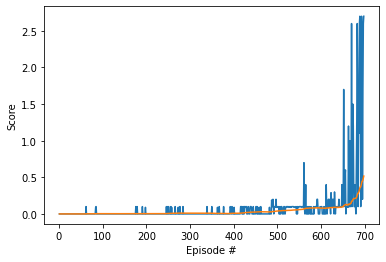

In [7]:
fig, ax = plt.subplots()
x = np.arange(1, len(scores) + 1)
ax.plot(x, scores)
ax.plot(x, mean_scores)
ax.set_ylabel('Score')
ax.set_xlabel('Episode #')
fig.savefig(config.scores_path)
plt.show()

When finished, you can close the environment.

In [8]:
config.env.close()